# Обзор
В этом ноутбуке проанализируем данные и подготовим их в том виде, который подходит для моделей машинного обучения: 
1) нам нужно обработать текстовые данные 
2) получить представление дерева категорий в виде направленного графа.

In [1]:
import sys
import numpy as np
import pandas as pd
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import nltk
from nltk.corpus import stopwords
import pymorphy2
import collections
import itertools
import hier
import re

from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

pd.set_option("max_colwidth", 25)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format

cmap = ListedColormap(['dodgerblue', 'lightgray', 'darkorange'])

Загрузим файлы, посмотрим количество образцов и оптимизируем занимаемую ими память

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
cats = pd.read_csv('categories_tree.csv',index_col='id')

hier.reduce_mem(train)
hier.reduce_mem(test)

print('Shapes: ',train.shape, test.shape, cats.shape)

Shapes:  (283452, 7) (70864, 6) (3370, 2)


In [3]:
train[:3]

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочн...,Muhle Manikure Колпач...,None,0.000,0,2693
1,128833,Sony Xperia L1 Защитн...,None,None,4.668,9,13408
2,569924,Конверт для денег Пре...,Конверт для денег «Пр...,None,5.000,6,11790


Переименуем столбцы для удобства:

In [4]:
train.columns = ['id','title','description','characteristics','rating','feedback','category_id']
test.columns = train.columns[:-1]
train[:1]

,id,title,description,characteristics,rating,feedback,category_id
0,1267423,Muhle Manikure Песочн...,Muhle Manikure Колпач...,None,0.000,0,2693


In [5]:
train.dtypes

id                   int32
title               object
description         object
characteristics     object
rating             float16
feedback             int16
category_id          int16
dtype: object

# Обработка текстовых признаков
В тренировочных данных много не заполненных значений в кратком описании и характеристиках, также с нулевым рейтингом (что скорее всего означает что вообще рейтинг не ставился) и нулевым количеством отзывов

In [6]:
train.isna().sum() / train.shape[0]

id                0.000
title             0.000
description       0.530
characteristics   0.822
rating            0.000
feedback          0.000
category_id       0.000
dtype: float64

In [7]:
print('Доля образцов с 0 рейтингом и 0 отзывами: ', round((train.rating == 0).mean(),2), round((train.feedback == 0).mean(),2))


Доля образцов с 0 рейтингом и 0 отзывами:  0.61 0.61


В столбце characteristics много инфы о размерах товара, но есть и данные, которые указывают на другой товар, к которому текущий товар имеет отношение: например текущий товар - защитная пленка, а в описании указаны телефоны для пленки. Это может добавить разброс в классификацию.

In [8]:
train[train['characteristics'].notna()].sample(5)

,id,title,description,characteristics,rating,feedback,category_id
210195,480327,Ушат медный для бани,None,Объём:3л|5л,0.000,0,12010
88274,1025501,Чехол для iPhone 11 ...,None,Модель:iPhone 11,5.000,2,11937
197322,1223456,"Крем для рук, 30 г",None,состав:с маслом Ши|с ...,0.000,0,11957
180498,1011466,Детское платье Эльзы ...,Для маленьких модниц ...,Размер платья:100|110...,5.000,10,14549
219776,945292,"Одеяло всесезонное, П...","Одеяло всесезонное, П...",Размер::140x205|172x2...,5.000,1,12483


Добавим в признаки столбцы, показывающие есть ли для образца описание и характеристики, возможно продавцы конкретных товаров не добавляют их, и по этому можно будет их отличить друг от друга

In [9]:
for df in [train, test]:
    df["has_description"] = df["description"].notna().astype(int)
    df["has_characteristics"] = df["characteristics"].notna().astype(int)    

In [10]:
train[:1]

,id,title,description,characteristics,rating,feedback,category_id,has_description,has_characteristics
0,1267423,Muhle Manikure Песочн...,Muhle Manikure Колпач...,None,0.000,0,2693,1,0


Проверяем, что столбец id уникальный для трейна и теста и не содержит никакой информации:

In [11]:
print(set(train['id']).intersection(set(test['id'])))
train['id'].nunique() == train.shape[0], test['id'].nunique() == test.shape[0]

set()


(True, True)

Так как по визуальному осмотру инфа в description часто похожа на title, а в characteristics много отсутствующих значений и инфа в нем имеет дополнительных характер - то сконкатенируем их через пробел еще в двух  вариантах: title+description в столбец title_desc, title+description+characteristics в столбец title_desc_chars. 

Очистим текст в исходных столбцах по отдельности, а потом соединим.

Почистим текстовые столбцы от нерелеватных символов и слов:
1) заполним None и приведем к нижнему регистру
2) удалим веб ссылки
3) удалим все знаки препинания
4) удалим отдельно стоящие цифры
5) заменим выражения типа "20х20см" на "см", "220v" на "volt", "200г" на "гр". Возможно они нерелевантные, но пока оставим, так как 220v может указывать на категорию электроники, а 1л на жидкости. Но, выражения неочевидные, особенно частые, типа 6s заменять не будем, они могут указывать на какую-то область электроники.
6) пробовал исправить опечатки русских слов с jamspell, но с дефолтными настройками, получилось некачественно, можно натренировать потом для качественного исправления
7) удалим стоп слова
8) добавим опцию для удаления дубликатов слов, потому что часто содержание title и description повторяется и возможно внесет лишний разброс в данные. Но можно протестировать. Для моделей, которые учитывают окружение слова, дубликаты помогут сохранить целостность контекста. Минус удаления дубликатов в том, что у нас title и description очень похожи, а после преобразования получится title+description, например "Коврик быстрой мышки. Красивый коврик для дома.". После удаления дубликатов получится "Коврик быстрой мышки. Красивый дом.". Второе предложение некорректное.
9) лемматизируем с pymorphy2
10) удалим слова, которые встречаются реже чем min_rare_words=2 (например) раз на весь датасет

Загружаем стоп-слова:

In [12]:
def get_stopwords():
    nltk.download("stopwords")
    with open('stopwords.txt', 'r') as f:
        additional_stopws = f.read().split()
    return set(additional_stopws + stopwords.words("russian"))

stopws = get_stopwords()  # все стоп-слова

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функции для очистки текста:

In [13]:
morph = pymorphy2.MorphAnalyzer()

repls = {
    "м": "метр",
    "v": "вольт",
    "в": "вольт",
    "w": "ватт",
    "см": "см",
    "sm": "см",
    "mm": "мм",
    "мм": "мм",
    "ml": "мл",
    "мл": "мл",
    "h": "час",
    "г": "гр",
    "g": "гр",
    "л": "литр",
    "mah": "мач",
    "ah": "ач",
    "гб": "гб",
    "gb": "гб",
    "mb": "мб",
    "мб": "мб",
     "kb": "кб",
    "кб": "кб",
    "tb": "тб",
    "тб": "тб",
}


def lemmatize(token):
    return morph.normal_forms(token)[0]


# возвращает статистику по количеству каждого слова в столбце
def word_counts(text_col):
    words = list(text_col.str.split())

    words_no = collections.Counter(itertools.chain(*words))
    word_stats = pd.DataFrame(words_no.most_common(), columns=["words", "count"])
    return word_stats


# исправление опечаток - нужна тренировка корректора
# jsp = jamspell.TSpellCorrector()
# assert jsp.LoadLangModel('ru.bin')
# def correct_typos(token):
#     token_without_typos = jsp.FixFragment(token)
#     return token


def drop_dupls(text):
    tokens = []
    for token in text.split():
        if token not in tokens:
            tokens.append(token)
    return " ".join(tokens)


def remove_rare_words(rare_words):
    def remove_(text):
        tokens = []
        for token in text.split():
            if token not in rare_words:
                tokens.append(token)
        return " ".join(tokens)

    return remove_


# удаление стоп-слов, лематизация
def clean_by_word(text):
    tokens = []
    for token in text.split():
        if len(token) < 2:
            continue

        if ("а" <= token[0] <= "я") and ("а" <= token[-1] <= "я"):
            token = lemmatize(token)

        parts = re.split("\d+", token)
        if len(parts) > 1:
            w = repls.get(parts[-1])
            if w:
                token = w

        if token not in stopws:
            tokens.append(token)

    return " ".join(tokens)


def clean_text(text_col, drop_duplicates=False):
    # понижение регистра, удаление ссылок и знаков препинания
    text_col = text_col.str.lower()
    text_col = text_col.str.replace(r"http\S+", "", regex=True)
    text_col = text_col.str.replace("[^A-Za-z0-9А-Яа-я]+", " ", regex=True)

    # удаление отдельно стоящих цифр
    text_col = text_col.str.replace("(?<=\s)[\d\s]+(?=\s)", "", regex=True)
    text_col = text_col.str.replace("^\d+(?=\s)|(?<=\s)\d+$", "", regex=True)

    # удаление таких последовательностей 50х50x50
    text_col = text_col.str.replace("\d+[x,х,×][\d,x,х,×]+", " 777", regex=True)
    text_col = text_col.str.replace("(?<=\s)777(?=\s)", "", regex=True)

    # удаление стоп-слов, опечаток, лематизация
    text_col = text_col.apply(clean_by_word)

    # удаление дубликатов слов в одном образце
    if drop_duplicates:
        text_col = text_col.apply(drop_dupls)

    return text_col

Применяем функции - очищаем текстовые данные:

In [14]:
%%time
for df in [train, test]:
    df["description"] = df["description"].fillna("")
    df["characteristics"] = df["characteristics"].fillna("")

    df["title"] = clean_text(df["title"])
    df["description"] = clean_text(df["description"])
    df["characteristics"] = clean_text(df["characteristics"])

CPU times: user 7min 49s, sys: 230 ms, total: 7min 49s
Wall time: 7min 49s


In [15]:
train[:1]

,id,title,description,characteristics,rating,feedback,category_id,has_description,has_characteristics
0,1267423,muhle manikure песочн...,muhle manikure колпач...,,0.000,0,2693,1,0


Самые частые слова:

In [16]:
all_text = pd.concat([train["title"],train["description"],train["characteristics"]],ignore_index=True)
word_stats = word_counts(all_text)
word_stats[:10]

,words,count
0,женский,33281
1,размер,32442
2,мл,23674
3,iphone,21527
4,чехол,21515
5,набор,20702
6,носка,19549
7,волос,19296
8,pro,16439
9,детский,14407


Самые редкие слова:

In [17]:
word_stats[-10:]

,words,count
67285,размре,1
67286,в48,1
67287,маияга,1
67288,тиффанни,1
67289,hundai,1
67290,koleos,1
67291,холл,1
67292,нильский,1
67293,шератон,1
67294,цитранелла,1


Удалим редкие слова, которые встречаются меньше 3 раз:

In [18]:
min_rare_words = 3
rare_words = set(word_stats.loc[word_stats["count"] < min_rare_words, "words"])
len(rare_words)

39118

In [19]:
%%time
for df in [train,test]:
    for col in ["title", "description", "characteristics"]:
        df[col] = df[col].apply(remove_rare_words(rare_words))

CPU times: user 1.18 s, sys: 8 µs, total: 1.18 s
Wall time: 1.18 s


Добавляем агрегированные столбцы 'title_desc', 'title_desc_chars'

In [20]:
for df in [train, test]:
    df["title_desc"] = df["title"].str.cat(df["description"], sep=" ").str.strip()
    df["title_desc_chars"] = (
        df["title_desc"].str.cat(df["characteristics"], sep=" ").str.strip()
    )
    
# удаляем из тренировочного датасета строки с пустыми текстовыми признаками, которые могли возникнут после всех чисток
train = train[
    (train["title"] != "")
    & (train["title_desc"] != "")
    & (train["title_desc_chars"] != "")
]

In [22]:
list(train['title_desc_chars'].sample(3))

['шорты детский',
 'японский бигуди набор коклюшка химический завивка прикорневой объём предназначить разнообразный вид био химический завивка',
 'профессиональный машинка триммер волос борода усов профессиональный машинка триммер волос борода усов']

Сохраним подготовленные датафреймы, изменив типы, чтобы некоторые мл модели не выдавали ошибки:

In [24]:
def prepare_fo_ml(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            df[col] = df[col].astype(np.float32)
        elif str(col_type)[:3] == "int":
            df[col] = df[col].astype(np.int32)
            
    return df

train = prepare_fo_ml(train.copy())
test = prepare_fo_ml(test.copy())

train.to_parquet('train_data.parquet',index=False)
test.to_parquet('test_data.parquet',index=False)       

Посмотрим статистику по словам. 50 самых частых слов в трейне:

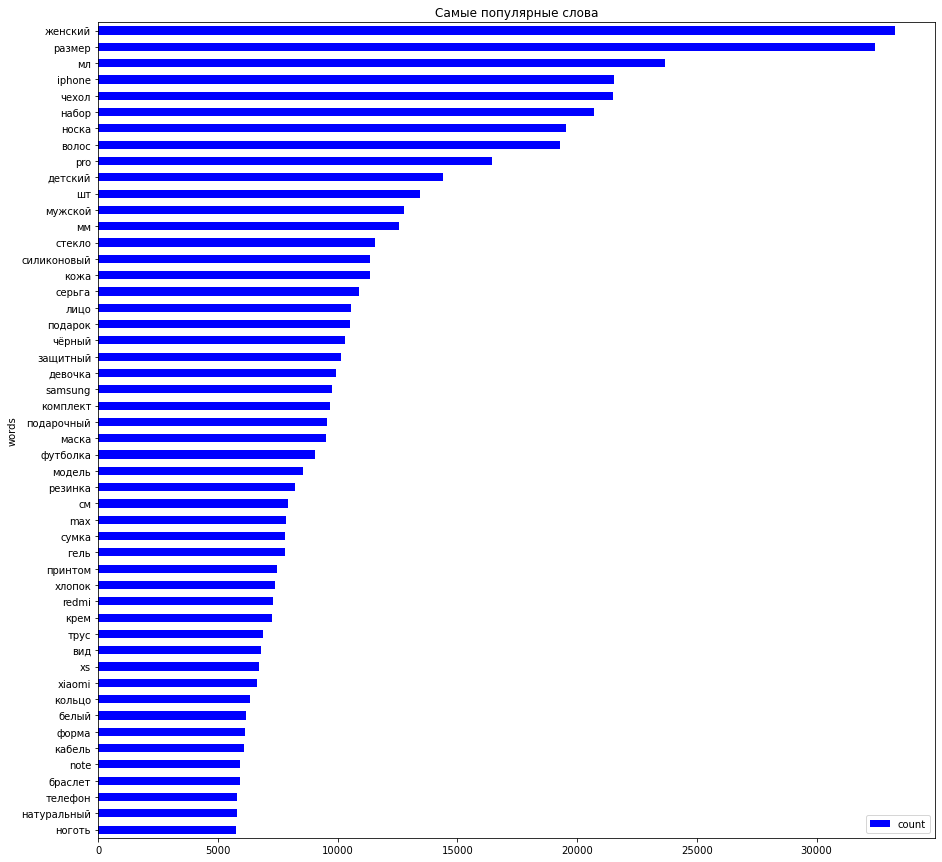

In [25]:
n = 50
word_stats = word_counts(train['title_desc_chars'])
fig, ax = plt.subplots(figsize=(15, 15))
word_stats[:n].sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="blue")
_ = ax.set_title("Самые популярные слова")

In [27]:
print('Количество уникальных слов в трейне: ',len(word_stats))
print('Общее слов в трейне: ',sum(word_stats['count']))

Количество уникальных слов в трейне:  28177
Общее слов в трейне:  2712406


Распределение по количеству слов. В столбце title_desc_chars большинство текстов меньше 50 слов:

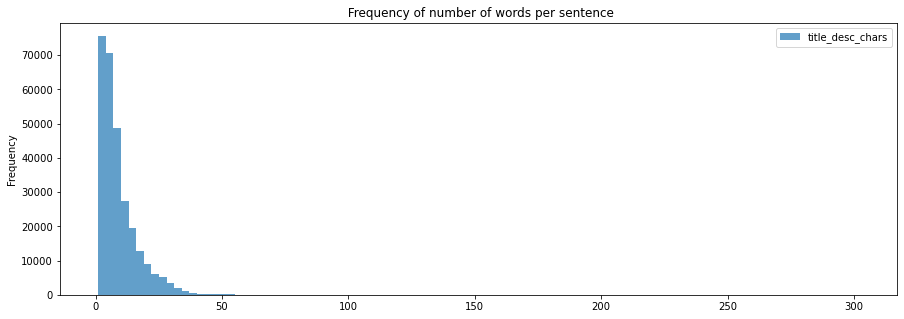

In [28]:
_ = train['title_desc_chars'].str.split().\
    map(lambda x: len(x)).plot.hist(bins=100, alpha=0.7, figsize=(15,5), title=' Frequency of number of words per sentence', legend=True)

Неуникальных русских слов примерно в 6 раз больше чем английских, но неизвестно английские слова имеют реальное значение или это абстрактные марки, модели и т.д.:

In [29]:
def ru_en(word):
    if ("а" <= word[0] <= "я") and ("а" <= word[-1] <= "я"):
        return 'ru'
    elif ("a" <= word[0] <= "z") and ("a" <= word[-1] <= "z"):
        return 'en'
    else:
        return 'something'

word_stats['lang'] = word_stats['words'].apply(ru_en).astype('category')
word_stats[:4]

,words,count,lang
0,женский,33279,ru
1,размер,32437,ru
2,мл,23674,ru
3,iphone,21527,en


In [30]:
number_words = word_stats.groupby('lang').agg(number_all_words=('count','sum'),number_uniq_words=('count','count'))
number_words

,number_all_words,number_uniq_words
lang,,
en,373599,7638
ru,2238054,17155
something,100753,3384


In [31]:
number_words / number_words.sum(axis=0)

,number_all_words,number_uniq_words
lang,,
en,0.138,0.271
ru,0.825,0.609
something,0.037,0.120


Проанализируем описания товаров с помощью частоты встречаемости слов в конкретном образце и в целом в датасете. Для этого преобразуем title c TfidfVectorizer, этим мы масштабируем информативность слов, возьмем слова встречавшиеся больше min_df=5 раз в трейне.

In [29]:
tf = TfidfVectorizer(min_df=5, lowercase=False)
X = tf.fit_transform(train['title'])
X.shape

(283400, 18955)

Признаки с низкими значениями tf-idf – это признаки, которые либо
встречаются во многих документах, либо используются редко и только в
очень длинных документах, они врядли помогут классификации, поэтому какие-то из них внесем в стоп-лист (который у нас в виде файла stopwords.txt).
Признаки с высокими значениями tf-idf - наиболее информативные с точки зрения такого преобразования.

In [30]:
max_value = X.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(tf.get_feature_names_out())

print("Признаки с наименьшими значениями tf-idf:\n{}".format(
feature_names[sorted_by_tfidf[:20]]))
print("Признаки с наибольшими значениями tf-idf: \n{}".format(
feature_names[sorted_by_tfidf[-20:]]))

Признаки с наименьшими значениями tf-idf:
['упить' 'дисперсный' 'ь200' 'бралет' '60с' 'стереозвуков' 'заморочить'
 '3air' 'a2lite' 'танглтизер' 'суперски' 'protex' 'a1466' 'a1398'
 'тейпирование' 'cвета' 'собои' 'corgizodiak' 'размочить' 'микровискоза']
Признаки с наибольшими значениями tf-idf: 
['ползунок' 'постер' 'а5' 'портупея' 'портмоне' 'попсокет' 'автодокумент'
 'автоматический' 'помпон' 'адаптер' 'помада' 'полый' 'аккумулятор'
 'полукомбинезон' 'полотенце' 'акустический' 'половник' 'полка' 'бодить'
 'пирамида']


Посмотрим слова с низким значением обратной частоты документа tf.idf_, то есть слова, которые встречаются часто и менее важные. Внесем часть в стоп-лист.

In [31]:
sorted_by_idf = np.argsort(tf.idf_)
print("Признаки с наименьшими значениями idf:\n{}".format(
feature_names[sorted_by_idf[:100]]))

Признаки с наименьшими значениями idf:
['размер' 'женский' 'мл' 'чехол' 'набор' 'волос' 'носка' 'детский'
 'силиконовый' 'шт' 'мужской' 'iphone' 'подарок' 'кожа' 'чёрный' 'стекло'
 'модель' 'защитный' 'лицо' 'комплект' 'девочка' 'подарочный' 'мм'
 'samsung' 'серьга' 'pro' 'футболка' 'хлопок' 'вид' 'маска' 'принтом'
 'резинка' 'гель' 'сумка' 'крем' 'белый' 'стильный' 'телефон'
 'натуральный' 'xiaomi' 'см' 'форма' 'трус' 'яркий' 'ноготь' 'xs' 'кабель'
 'упаковка' 'кольцо' 'браслет' 'мальчик' 'прозрачный' 'любой' 'платье'
 'универсальный' 'galaxy' 'украшение' 'новогодний' 'масло' 'пакет'
 'мягкий' 'шапка' 'дизайн' 'удобный' 'тело' 'usb' 'шар' 'длина' 'apple'
 'держатель' 'увлажнять' 'redmi' 'материал' 'открытка' 'max' 'подвеска'
 'коробка' 'одежда' 'рисунок' 'брюки' 'гр' 'костюм' 'унисекс' 'наушник'
 'цепочка' 'хлопковый' 'лак' 'высокий' 'метр' 'пижама' 'xl' 'подставка'
 'бельё' 'huawei' 'качество' 'глаз' 'спортивный' 'часы' 'рука' 'заколка']


Так как у нас задача не просто классификации, а иерархической классификации, то я пока не стал удалять из тренировочных данных все такие слова, потому что tfidf считается здесь на весь датасет, а например в модели машинного обучения с локальными классификаторами, у нас будут как бы локальные датасеты, в которых если пересчитать, tfidf уже может иметь другие значения.

Датасет очень несбалансированный, есть много категории, которые имеют всего несколько образцов:

In [12]:
cat_counts = train.category_id.value_counts()
cat_counts

11937    14967
13408     7153
13061     6434
13143     6145
13253     3390
         ...  
13756        2
13007        2
2598         2
11917        2
13787        2
Name: category_id, Length: 1231, dtype: int64

Возьмем 20 самых больших категорий и отобразим их на двумерное пространство, снизив размерность TruncatedSVD, который работает лучше с sparse данными. 

In [34]:
n_big_cats = 20
data = train[train.category_id.isin(cat_counts.index[:n_big_cats])]
data.shape

(74896, 5)

По графику видно, что даже TfidfVectorizer-векторизация немного разделяет категории.

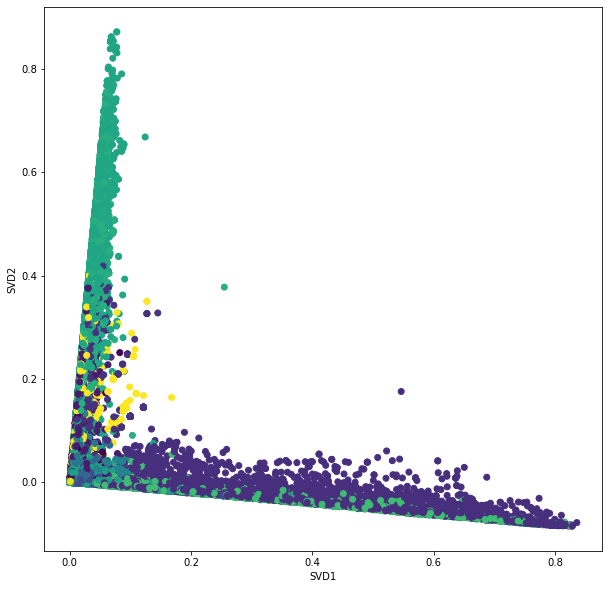

In [38]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)

tf = TfidfVectorizer(min_df=5, lowercase=False)
X_svd = tf.fit_transform(data['title'])
X_svd = svd.fit_transform(X_svd)

plt.figure(figsize=(10,10))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=data['category_id'])
plt.xlabel('SVD1')
_ = plt.ylabel('SVD2')

# Построение графа категорий
Представим дерево наших категориии в виде ориентированного ациклического графа (directed acyclic graph) с помощью библиотеки networkx

In [3]:
# категории
cats[:5]

,title,parent_id
id,,
1,Все категории,0
114,Урбеч,1913
115,Варенье и джемы,328
128,Сухие завтраки,2475
131,Масла,2475


Для этого для каждой категории найдем всех ее родителей вплоть до корневой категории 0 и оставим только те листовые категории, которые есть в тренировочных данных. (По родителям листовых категорий мы восстановим все узловые категории) Сохраним в датафрейм parents.

In [4]:
parents = cats.copy()
parents.columns=['title', 'parent_1']

for i in range(2,100):
    parents = parents.merge(cats[['parent_id']], how='left',left_on=parents.columns[-1],right_index=True).rename(columns={'parent_id':f'parent_{i}'})
    if parents.iloc[:,-1].sum() ==0:
        break

parents.iloc[:,1:] = parents.iloc[:,1:].fillna(0).astype(np.int16)

# уникальные листовые категории в тренировочных данных
uniq_leaves = train['category_id'].unique()
uniq_leaves.sort()
print('Количество уникальных листовых категорий: ', len(uniq_leaves))

parents = parents.reindex(uniq_leaves).reset_index()

print(parents.shape)
parents[:7]

Количество уникальных листовых категорий:  1231
(1231, 8)


,id,title,parent_1,parent_2,parent_3,parent_4,parent_5,parent_6
0,2598,Комбинезоны домашние,10418,10116,10014,1,0,0
1,2599,Купальники,11351,10116,10014,1,0,0
2,2600,Пляжная одежда,11351,10116,10014,1,0,0
3,2601,Майки и топы бельевые,11351,10116,10014,1,0,0
4,2602,Корректирующее белье,11351,10116,10014,1,0,0
5,2603,Комбинезоны домашние,10445,10052,10014,1,0,0
6,2604,Майки и футболки,10937,10052,10014,1,0,0


Найдем уникальные (узловые и листовые) категории среди тренировных данных - получилось 1477 категорий (из них 1231 листовые)

In [5]:
uniq_nodes = np.unique(parents[[col for col in parents.columns if col != 'title']])
len(uniq_nodes), uniq_nodes[:7]

(1477, array([   0,    1, 2598, 2599, 2600, 2601, 2602]))

В networkx нет листов, есть только узлы (nodes) и грани (edges). Построим граф G сначала по всем возможным категориям в cats. Потом удалим из него все категории, которых нет в наших тренировочных данных. Также удалим категорию 0, у которой единственный потомок это категория 1, поэтому 0 не нужна.

In [6]:
G = nx.from_pandas_edgelist(cats['parent_id'].reset_index(), 'parent_id', 'id', create_using=nx.DiGraph())
G = nx.subgraph(G, uniq_nodes).copy()
G.remove_node(0)
print('Общее количество листовых и узловых категорий в графе',len(G))

Общее количество листовых и узловых категорий в графе 1476


У графа можно посмотреть, например, количество категорий на каждом уровне ветвления, и какие категории на уровне расположены.

In [7]:
# количество категорий на каждом уровне начиная с корня
print('количество',[len(generation) for generation in nx.topological_generations(G)])

# категории на верхних 2 уровнях
print([generation for generation in nx.topological_generations(G)][:2])

количество [1, 5, 50, 385, 982, 53]
[[1], [10003, 10012, 10014, 10018, 10020]]


нарисуем верхнюю часть графа, укажем сколько максимум узлов отобразить - n

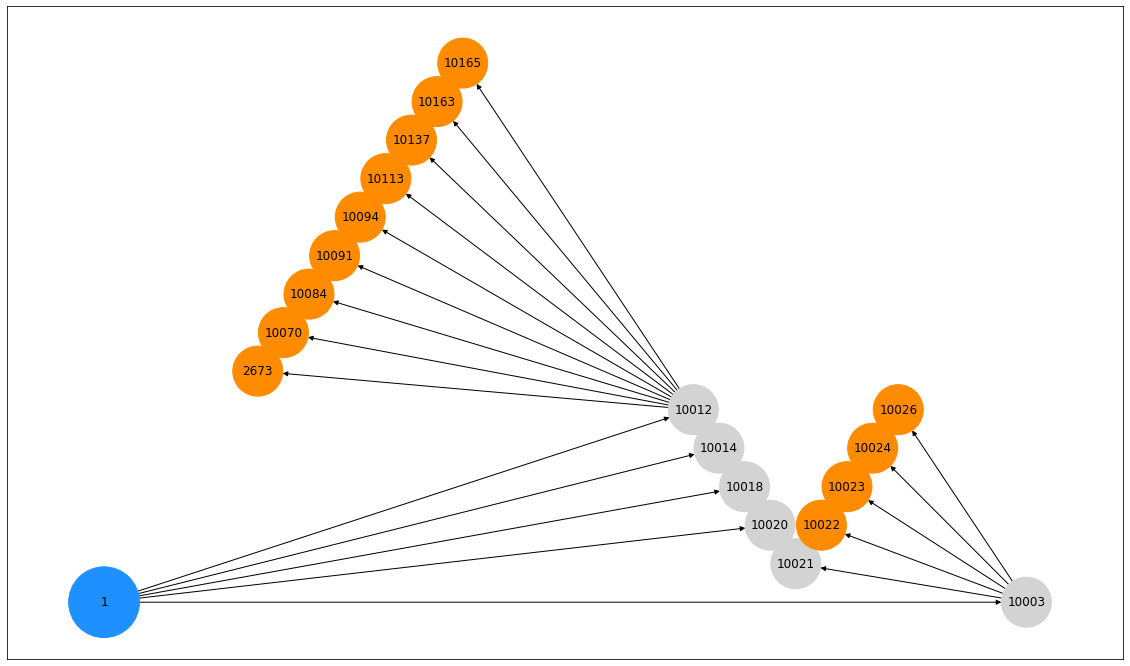

In [11]:
def draw_top_graph(G, n=20):
    fig, ax = plt.subplots(figsize=(20,12))
    top_nodes = list(nx.topological_sort(G))[:n]
    G = G.subgraph(top_nodes)
    
    colors = {1:0, 10012:1, 10014:1, 10018:1, 10020:1, 10021:1, 10003:1}
    node_colors = [colors.get(node,2) for node in list(G)]

    node_sizes = [5000 if node == 1 else 2500 for node in list(G)]
    
    nx.draw_networkx(G, pos=nx.planar_layout(G), node_color=node_colors, node_size=node_sizes,cmap=cmap)
    
draw_top_graph(G, n=20)

Сохраним граф и родителей категорий в файлы:

In [9]:
nx.write_gpickle(G, "graph.gpickle")
parents.to_csv('parents.csv',index=False)

Маленькие по обьему категории могут создать шум для классификаторов при определении больших категорий, снизив их качество, поэтому возможно стоит 1) все маленькие категории обьединить в одну категорию на весь трейн датасет, или 2) сгруппировать их в пределах первого родителя. 193 категории имеют меньше 10 образцов

In [13]:
THRESHOLD_SMALL = 10
small_cats = cat_counts[cat_counts<THRESHOLD_SMALL].index
small_cats

Int64Index([13416, 12901, 14135, 12596, 12677, 13754, 14165,  2860,  2676,
            12936,
            ...
            13626,  2854, 12542, 13378, 12385, 13756, 13007,  2598, 11917,
            13787],
           dtype='int64', length=193)